# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Step 1

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**profile.json**</br>
Rewards program users (17000 users x 5 fields)<br/>
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**portfolio.json**<br/>
Offers sent during 30-day test period (10 offers x 6 fields)<br/>
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**transcript.json**<br>
Event log (306648 events x 4 fields)<br/>
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib as pl
from collections import defaultdict
import sagemaker
from sklearn.model_selection import train_test_split
from sagemaker.xgboost.estimator import XGBoost
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import boto3
#% matplotlib inline

In [4]:
# data.info() fails, so:
#!pip3 install numpy --upgrade
#!pip3 install numpy==1.21.4
#!pip install numpy==1.19.5
print(boto3.__version__)
print(pd.__version__)

#https://stackoverflow.com/questions/66563463/how-to-treat-attribute-dtype-of-numpy-generic-objects-error

1.20.23
1.0.1


In [9]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [14]:
#profile.info() #not working
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

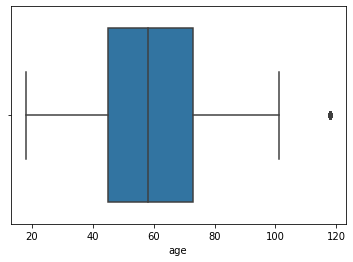

In [81]:
# First look at a frame:
import seaborn as sns
sns.boxplot(x=profile['age'])

We clearly see outliers in age feature (point at the far right) that\ 
      we will have to eliminate, but first, we will create a big tabular\
      frame with all the data and after dat we will try to get rid of errors in data

# Creating the tabular data and performing EDA and Data cleaning

### <font color=grey> *Since we have 3 different files, that contain transactions, demographic data, and kind of offer data, we need to simplify all that information in only ona big table (pandas dataframe) to feed our estimator. So we will merge the data in the dataframes adding to the largest frame the data of the users and the offer details* </font>

In [82]:
print(portfolio.shape)
portfolio.head()

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [83]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [85]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [54]:
#We will expand the dictionary contained in the column 'value' 
#to get the offer id in a separated column
#https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

# step 1: convert the `value` column to Pandas dataframe series
transcript_value = transcript['value'].apply(pd.Series)
# step 2: concat resulting columns and drop/remove the `value` 
transcript_exploded = pd.concat([transcript, transcript_value], axis = 1).drop('value', axis = 1)

In [150]:
#The result
transcript_exploded.head()

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [56]:
#Let's check the contents of offer_id and "offer id" colums:
transcript_exploded.isnull().sum()

person           0
event            0
time             0
offer id    172532
amount      167581
offer_id    272955
reward      272955
dtype: int64

In [57]:
#we see that the collumn offer_id has almost all values empty
#Let's check the event column to see what events are recorded in the transactions:
transcript_exploded['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [58]:
#we don't want the "transaction" event, because these are not refering to offers
transcript_offers = transcript_exploded[~transcript_exploded['event'].str.contains('transaction')]

In [59]:
transcript_offers.isnull().sum()

person           0
event            0
time             0
offer id     33579
amount      167581
offer_id    134002
reward      134002
dtype: int64

In [60]:
transcript_offers['offer_id'].nunique()

8

In [61]:
transcript_offers['offer id'].nunique()

10

In [62]:
#We will fill the blanks in "offer id", with non blanks in offer_id
#https://stackoverflow.com/questions/58303311/replace-a-column-with-another-column-if-another-is-not-null-in-pandas-dataframe   
#df['v_5'] = np.where(~df['pfv'].isnull(),df['pfv'],df['v_5']))
df = transcript_offers.copy()
df['offer id'] = np.where(df['offer id'].isnull() & df['offer_id'].notnull(), df['offer_id'], df['offer id'])
df['offer_id'].nunique()

8

In [63]:
# We successfully put the offer ids from offer_id to offer id
df.isnull().sum()

person           0
event            0
time             0
offer id         0
amount      167581
offer_id    134002
reward      134002
dtype: int64

In [64]:
# Now we drop offer_id with a lot of missing values and the not missing already copied 
# into "offer id" and then we'll rename the column
df.drop('offer_id', axis=1, inplace=True)
df.rename({'offer id': 'offer_id'}, axis=1, inplace=True)

In [65]:
df.isnull().sum()

person           0
event            0
time             0
offer_id         0
amount      167581
reward      134002
dtype: int64

In [66]:
df.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [67]:
# Now we can unify columns that connect different dataframes
df.rename({'person': 'person_id'}, axis=1, inplace=True)
df.head()

,person_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [68]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [69]:
profile = profile.rename(columns={"id":"person_id"})
profile.head()

,gender,age,person_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [70]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [71]:
#Portfolio feature id is actually the offer_id, so we rename it
portfolio.rename({'id': 'offer_id'}, axis=1, inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [72]:
# Finally we merge all data
transcript_only_offers = pd.merge(df, portfolio, on="offer_id")
data = pd.merge(transcript_only_offers, profile, on="person_id")
data.head()

,person_id,event,time,offer_id,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5,"[web, email, mobile, social]",5,5,bogo,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5,"[web, email, mobile, social]",5,5,bogo,F,75,20170509,100000.0


In [73]:
data.isnull().sum()
#data.count()

person_id                0
event                    0
time                     0
offer_id                 0
amount              167581
reward_x            134002
reward_y                 0
channels                 0
difficulty               0
duration                 0
offer_type               0
gender               18776
age                      0
became_member_on         0
income               18776
dtype: int64

In [74]:
# We kept around half of the data, but still have a lot of missing values in gender, amount, reward_x, and income. So we will
# get rid of them, since we need that data clean
# amount and reward_x are mostly empty, so we drop those columns:
  
data.drop('amount', axis=1, inplace=True)
data.drop('reward_x', axis=1, inplace=True)
data.head()

,person_id,event,time,offer_id,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,F,75,20170509,100000.0


In [98]:
#data.info() #not working beacuse of numpy conflict

In [40]:
data.isnull().sum()

person_id               0
event                   0
time                    0
offer_id                0
reward_y                0
channels                0
difficulty              0
duration                0
offer_type              0
gender              18776
age                     0
became_member_on        0
income              18776
dtype: int64

In [76]:
print(np.__version__)
#data.info()

1.20.3


In [87]:
transcript['event'].count()

306534

In [88]:
data['event'].count()

167581

# EDA and Data cleaning
### <font color=grey> *Looking for missing data and outliers, class imbalance and clean the data* </font>


In [89]:
# Missing data
data.isnull().sum()

person_id               0
event                   0
time                    0
offer_id                0
reward_y                0
channels                0
difficulty              0
duration                0
offer_type              0
gender              18776
age                     0
became_member_on        0
income              18776
dtype: int64

In [91]:
# Finally we get rid of rows with missing data:
data.dropna(inplace=True)
#data.info()
data.head()

,person_id,event,time,offer_id,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,F,75,20170509,100000.0


In [92]:
data.describe()

,time,reward_y,difficulty,duration,age,became_member_on,income
count,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,1.488050e+05,148805.000000
mean,354.570223,4.442445,7.890561,6.625207,54.779282,2.016645e+07,66414.119149
std,198.311301,3.372362,5.041335,2.133035,17.193533,1.176936e+04,21496.947967
min,0.000000,0.000000,0.000000,3.000000,18.000000,2.013073e+07,30000.000000
25%,168.000000,2.000000,5.000000,5.000000,43.000000,2.016050e+07,51000.000000
50%,408.000000,5.000000,10.000000,7.000000,56.000000,2.017063e+07,65000.000000
75%,510.000000,5.000000,10.000000,7.000000,67.000000,2.017122e+07,81000.000000
max,714.000000,10.000000,20.000000,10.000000,101.000000,2.018073e+07,120000.000000


### Let's look for outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2dfc7b610>,
      dtype=object)

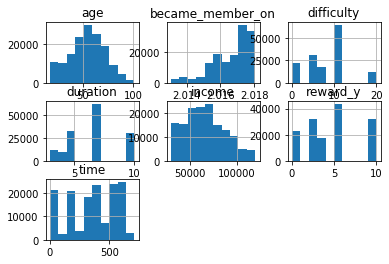

In [93]:
data.hist()

Doesn't seem to be outliers. We did find outliers before the cleaning, but now they are gone. That's good!

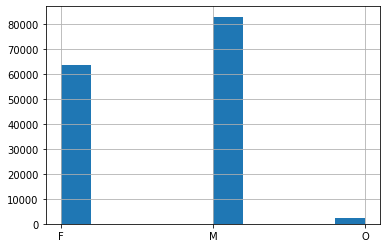

In [94]:
data['gender'].hist()

We can observe imbalance in the gender feature. O is poorly represented and M is about 40 percent larger.
This imbalance makes us to take the decision of using F1 as a metric instead of Accuracy
Reference: 
https://stats.stackexchange.com/questions/210700/how-to-choosebetween-roc-auc-and-f1-score<br/>
"To put in very simple words when you have a data imbalance i.e., the difference between the number of examples you have for positive and negative classes is large, you should always use F1-score. Otherwise you can use ROC/AUC curves."


In [95]:
#Let's see the different kind of events:
print(data['event'].value_counts())

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 167580
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person_id         148805 non-null  object 
 1   event             148805 non-null  object 
 2   time              148805 non-null  int64  
 3   offer_id          148805 non-null  object 
 4   reward_y          148805 non-null  int64  
 5   channels          148805 non-null  object 
 6   difficulty        148805 non-null  int64  
 7   duration          148805 non-null  int64  
 8   offer_type        148805 non-null  object 
 9   gender            148805 non-null  object 
 10  age               148805 non-null  int64  
 11  became_member_on  148805 non-null  int64  
 12  income            148805 non-null  float64
dtypes: float64(1), int64(6), object(6)
memory usage: 15.9+ MB


In [112]:
data.isnull().sum()

person_id           0
event               0
time                0
offer_id            0
reward_y            0
channels            0
difficulty          0
duration            0
offer_type          0
gender              0
age                 0
became_member_on    0
income              0
dtype: int64

In [113]:
data.count()

person_id           148805
event               148805
time                148805
offer_id            148805
reward_y            148805
channels            148805
difficulty          148805
duration            148805
offer_type          148805
gender              148805
age                 148805
became_member_on    148805
income              148805
dtype: int64

In [114]:
data.corr()

,time,reward_y,difficulty,duration,age,became_member_on,income
time,1.000000,0.005320,0.023295,0.025480,0.006074,-0.006365,0.004389
reward_y,0.005320,1.000000,0.421174,0.043448,0.000911,-0.000188,0.014786
difficulty,0.023295,0.421174,1.000000,0.766816,0.009898,-0.008430,0.026340
duration,0.025480,0.043448,0.766816,1.000000,0.006579,-0.013792,0.015368
age,0.006074,0.000911,0.009898,0.006579,1.000000,-0.009056,0.305096
became_member_on,-0.006365,-0.000188,-0.008430,-0.013792,-0.009056,1.000000,-0.022624
income,0.004389,0.014786,0.026340,0.015368,0.305096,-0.022624,1.000000


### Now that we have one tabular pandas dataframe named 'data' we will add the target value as last column, based on the data of offer_id, which is the one we want to predict and convert that string to proper numerical data.

In [115]:
data['target'] = data['offer_id']
data.drop('offer_id', inplace=True, axis=1)

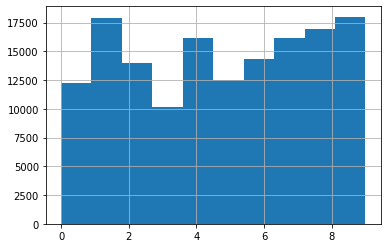

In [168]:
data['target'].hist()

In [141]:
lbl = preprocessing.LabelEncoder()
data['gender'] = lbl.fit_transform(data['gender'].astype(str))
data['target'] = lbl.fit_transform(data['target'].astype(str))
data['channels'] = lbl.fit_transform(data['gender'].astype(str))
data['offer_type'] = lbl.fit_transform(data['offer_type'].astype(str))
data['event'] = lbl.fit_transform(data['event'].astype(str))
#data.info()

In [142]:
data.dtypes

person_id                 object
event                      int64
time                       int64
reward_y                   int64
channels                   int64
difficulty                 int64
duration                   int64
offer_type                 int64
gender                     int64
age                        int64
became_member_on           int64
income                   float64
target                     int64
encoded_bogo               uint8
encoded_discount           uint8
encoded_informational      uint8
dtype: object

In [147]:
data.drop('person_id', inplace=True, axis=1)

In [143]:
data['event'].unique()

array([1, 2, 0])

In [140]:
data['gender'].unique()

array([0, 1, 2])

In [162]:
data['offer_type'].unique()

array([0, 2, 1])

In [161]:
data['channels'].unique()

array([0, 1, 2])

In [152]:
# Now we are ready to upload the data to s3
data.head()

,event,time,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income,target
0,1,0,5,0,5,7,0,0,75,20170509,100000.0,6
1,2,6,5,0,5,7,0,0,75,20170509,100000.0,6
2,0,132,5,0,5,7,0,0,75,20170509,100000.0,6
3,1,504,5,0,5,5,0,0,75,20170509,100000.0,8
4,0,510,5,0,5,5,0,0,75,20170509,100000.0,8


In [153]:
data.count()

event               148805
time                148805
reward_y            148805
channels            148805
difficulty          148805
duration            148805
offer_type          148805
gender              148805
age                 148805
became_member_on    148805
income              148805
target              148805
dtype: int64

In [154]:
data = data.drop_duplicates()

In [155]:
data.count()

event               148424
time                148424
reward_y            148424
channels            148424
difficulty          148424
duration            148424
offer_type          148424
gender              148424
age                 148424
became_member_on    148424
income              148424
target              148424
dtype: int64

In [163]:
data.corr()

,event,time,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income,target
event,1.000000,-0.064579,-0.044513,0.038126,-0.144825,-0.158209,0.094845,0.038126,-0.021610,0.051350,-0.053260,0.037294
time,-0.064579,1.000000,0.004949,-0.005277,0.022179,0.024483,-0.010597,-0.005277,0.006127,-0.006331,0.004062,-0.011347
reward_y,-0.044513,0.004949,1.000000,-0.011415,0.421939,0.043974,-0.837785,-0.011415,0.000673,-0.000029,0.014458,0.143689
channels,0.038126,-0.005277,-0.011415,1.000000,-0.011070,-0.003636,0.010749,1.000000,-0.133439,-0.014209,-0.203120,0.005847
difficulty,-0.144825,0.022179,0.421939,-0.011070,1.000000,0.766787,-0.295275,-0.011070,0.009615,-0.008471,0.025679,-0.276834
duration,-0.158209,0.024483,0.043974,-0.003636,0.766787,1.000000,-0.131739,-0.003636,0.006530,-0.013953,0.015035,0.008944
offer_type,0.094845,-0.010597,-0.837785,0.010749,-0.295275,-0.131739,1.000000,0.010749,-0.001802,0.006517,-0.013953,-0.364668
gender,0.038126,-0.005277,-0.011415,1.000000,-0.011070,-0.003636,0.010749,1.000000,-0.133439,-0.014209,-0.203120,0.005847
age,-0.021610,0.006127,0.000673,-0.133439,0.009615,0.006530,-0.001802,-0.133439,1.000000,-0.008962,0.304899,-0.006648
became_member_on,0.051350,-0.006331,-0.000029,-0.014209,-0.008471,-0.013953,0.006517,-0.014209,-0.008962,1.000000,-0.022651,-0.002441


In [165]:
# We drop channels since correlation with gender is 1
data.drop('channels', inplace=True, axis=1)

In [166]:
data.corr()

,event,time,reward_y,difficulty,duration,offer_type,gender,age,became_member_on,income,target
event,1.000000,-0.064579,-0.044513,-0.144825,-0.158209,0.094845,0.038126,-0.021610,0.051350,-0.053260,0.037294
time,-0.064579,1.000000,0.004949,0.022179,0.024483,-0.010597,-0.005277,0.006127,-0.006331,0.004062,-0.011347
reward_y,-0.044513,0.004949,1.000000,0.421939,0.043974,-0.837785,-0.011415,0.000673,-0.000029,0.014458,0.143689
difficulty,-0.144825,0.022179,0.421939,1.000000,0.766787,-0.295275,-0.011070,0.009615,-0.008471,0.025679,-0.276834
duration,-0.158209,0.024483,0.043974,0.766787,1.000000,-0.131739,-0.003636,0.006530,-0.013953,0.015035,0.008944
offer_type,0.094845,-0.010597,-0.837785,-0.295275,-0.131739,1.000000,0.010749,-0.001802,0.006517,-0.013953,-0.364668
gender,0.038126,-0.005277,-0.011415,-0.011070,-0.003636,0.010749,1.000000,-0.133439,-0.014209,-0.203120,0.005847
age,-0.021610,0.006127,0.000673,0.009615,0.006530,-0.001802,-0.133439,1.000000,-0.008962,0.304899,-0.006648
became_member_on,0.051350,-0.006331,-0.000029,-0.008471,-0.013953,0.006517,-0.014209,-0.008962,1.000000,-0.022651,-0.002441
income,-0.053260,0.004062,0.014458,0.025679,0.015035,-0.013953,-0.203120,0.304899,-0.022651,1.000000,-0.011701


## Now we can upload to s3

In [29]:
data_processed = pd.read_csv ('data/data_processed.csv')
#dropping this columns we got better results
columns_to_drop = ['event',
           'became_member_on',
           'reward_y',
           'time',
           'offer_type']

data_processed.drop(columns_to_drop, inplace=True, axis=1)
train, test = train_test_split(data_processed, test_size=0.2, random_state=0)

In [30]:
# We copy into the local dir
train.to_csv('data/data_processed/train.csv', index = False)
test.to_csv('data/data_processed/test.csv', index = False)
data_processed.to_csv('data/data_processed_small.csv', index = False)

In [31]:
import os
bucket = "starbucks-alela"
os.environ["DEFAULT_S3_BUCKET"] = bucket
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"



In [32]:
print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: starbucks-alela
AWS Region: us-east-1
RoleArn: arn:aws:iam::609011995334:role/service-role/AmazonSageMaker-ExecutionRole-20220121T121247


In [33]:
# We upload from local dir to s3
path_to_data_on_s3 = sagemaker.Session().upload_data(bucket=bucket, 
                                                  path='./data/data_processed', 
                                                  key_prefix='data_processed')

In [34]:
print(path_to_data_on_s3)

s3://starbucks-alela/data_processed


# Benchmark (Logistic Regression)
### Now that we have the data on s3, we will begin with the training part

In [5]:
# AWS Python SDK
import boto3
import os
from sagemaker import get_execution_role
bucket = "starbucks-alela"
os.environ["DEFAULT_S3_BUCKET"] = bucket
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

"""
data_key = 'data_processed/train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
print(data_location)
baseline_train=pd.read_csv(data_location)

data_key = 'data_processed/test.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
print(data_location)
baseline_test=pd.read_csv(data_location)
"""


"\ndata_key = 'data_processed/train.csv'\ndata_location = 's3://{}/{}'.format(bucket, data_key)\nprint(data_location)\nbaseline_train=pd.read_csv(data_location)\n\ndata_key = 'data_processed/test.csv'\ndata_location = 's3://{}/{}'.format(bucket, data_key)\nprint(data_location)\nbaseline_test=pd.read_csv(data_location)\n"

In [21]:
baseline_data = pd.read_csv ('data/data_processed.csv')
#dropping this columns we got better results
columns_to_drop = ['event',
           'became_member_on',
           'reward_y',
           'time',
           'offer_type']

baseline_data.drop(columns_to_drop, inplace=True, axis=1)
baseline_train, baseline_test = train_test_split(baseline_data, test_size=0.2, random_state=0)

In [22]:
baseline_test.head()

,difficulty,duration,gender,age,income,target
27010,10,7,2,71,86000.0,2
121318,10,10,0,48,90000.0,9
64111,10,7,0,63,79000.0,2
111553,0,4,1,74,41000.0,3
81847,5,5,1,66,76000.0,8


In [23]:
!date

Mon Jan 24 20:06:48 UTC 2022


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# saga supports more regularization types
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
baseline_model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000 )
X = baseline_train.iloc[:, :-1]
y = baseline_train.iloc[:, -1:]
baseline_model.fit(X, y.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
prediction = baseline_model.predict(baseline_test.iloc[:,:-1])
score=roc_auc_score(y, baseline_model.predict_proba(X), multi_class='ovr')
print(f"roc-auc-score: {score}")

roc-auc-score: 0.8350071584500596


In [26]:
!date

Mon Jan 24 20:18:39 UTC 2022


In [27]:
from sklearn.metrics import f1_score
prediction = baseline_model.predict(baseline_test.iloc[:,:-1])
score=f1_score(baseline_test["target"], prediction, average='weighted')
print(f"f1-score: {score}")

f1-score: 0.2996236877386956


#### The values of the metrics are a bit low, specially f1-score. We will try model with a more robust model to see if we can make things better.

#### roc-auc-score: 0.835008030477254
    
#### f1-score: 0.29966085611916776
    




# Model Training


We will use two different classification ensembre models to compare results first, we will create and evaluate a RandomForest model and then an XGBoost model

### RandomForest Training and evaluation

In [105]:
baseline_data = pd.read_csv ('data/data_processed.csv')
to_drop = ['event',
           'reward_y',
           'time',
           'offer_type',
           'duration',
           'became_member_on'
          ]

baseline_data.drop(to_drop, inplace=True, axis=1)
baseline_train, baseline_test = train_test_split(baseline_data, test_size=0.2, random_state=0)
baseline_data.corr()

,difficulty,gender,age,income,target
difficulty,1.000000,-0.011070,0.009615,0.025679,-0.276834
gender,-0.011070,1.000000,-0.133439,-0.203120,0.005847
age,0.009615,-0.133439,1.000000,0.304899,-0.006648
income,0.025679,-0.203120,0.304899,1.000000,-0.011701
target,-0.276834,0.005847,-0.006648,-0.011701,1.000000


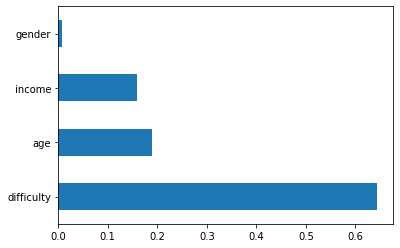

In [106]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

X = baseline_train.iloc[:, :-1] #all data except last  column
y = baseline_train.iloc[:, -1:] #only last column

benchmark_model = RandomForestClassifier()
benchmark_model.fit(X, y.values.ravel())

(pd.Series(benchmark_model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe164a43e90>,
      dtype=object)

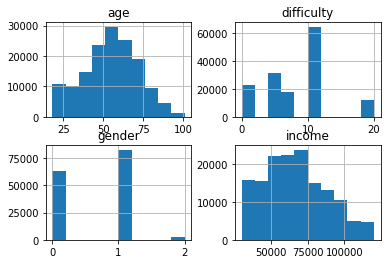

In [111]:
#Now that we know the important features, we will plot histograms for these:
baseline_data.hist(column=["gender", "difficulty", "income", "age"])#, legend=False)

In [112]:
from sklearn.metrics import f1_score
prediction = benchmark_model.predict(baseline_test.iloc[:,:-1])
score=f1_score(baseline_test["target"], prediction, average='weighted')
print(f"f1-score: {score}")

f1-score: 0.6248117840461341


[[2453    0    0    0    0    0    0    0    0    0]
 [   0 3578    0    0    0    0    0    0    0    0]
 [   0    0 1009    0  572    0    0  536    0  707]
 [   0    0    0 1121    0  847    0    0    0    0]
 [   0    0  520    0 1353    0    0  669    0  709]
 [   0    0    0  737    0 1741    0    0    0    0]
 [   0    0    0    0    0    0 1767    0 1054    0]
 [   0    0  536    0  640    0    0 1351    0  765]
 [   0    0    0    0    0    0  913    0 2470    0]
 [   0    0  582    0  672    0    0  658    0 1725]]


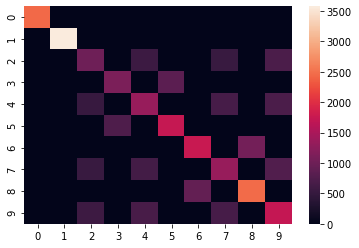

In [117]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(baseline_test["target"], prediction)
print(conf_mat)

#labels = baseline_test.columns.values.tolist()
#cmd_obj = ConfusionMatrixDisplay(cm, display_labels=labels)
#cmd_obj.plot()

# Visualize it as a heatmap
import seaborn
seaborn.heatmap(conf_mat)

This is a poor result and we will try to make it better using a more sofisticated model 
and performing hyperparameter optimization.

### XGBoost Training and evaluation

We will optimize parameters for a XGBoost model, and then we will perform
predictions on the best parameters found

In [36]:
import os
bucket = "starbucks-alela"
os.environ["DEFAULT_S3_BUCKET"] = bucket
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

output_path = 's3://{}/output'.format(bucket)
input_data = 's3://{}/'.format(bucket)

train_input = input_data + "data_processed/train.csv"
test_input = input_data + "data_processed/test.csv"


from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "max_depth": IntegerParameter(3, 10),
    "eta": ContinuousParameter(0.1, 0.8),
    "num_round" : CategoricalParameter([10, 30, 50, 100])
}

objective_metric_name = "validation:f1"

In [37]:
xgb_estimator = XGBoost(
    entry_point="model_train.py",
    role=role,
    instance_count=1,
    #instance_type="ml.m5.large",
    instance_type="ml.m5.2xlarge",
    framework_version="1.3-1",
    output_path=output_path,
)

tuner = HyperparameterTuner(
    xgb_estimator,
    objective_metric_name,
    hyperparameter_ranges, 
    max_jobs=2, 
    max_parallel_jobs=4 
)

In [38]:
!date

Mon Jan 24 20:27:23 UTC 2022


In [39]:
tuner.fit({'train': train_input, "validation": test_input})

.......................................................!


In [40]:
!date

Mon Jan 24 20:32:03 UTC 2022


In [41]:
#https://docs.aws.amazon.com/ko_kr/AWSJavaScriptSDK/v3/latest/clients/client-sagemaker/modules/finalhyperparametertuningjobobjectivemetric.html
#https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html
tuner.describe()['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']

{'MetricName': 'validation:f1', 'Value': 0.9110698103904724}

In [42]:
best_estimator = tuner.describe()['BestTrainingJob']['TunedHyperParameters']
print(best_estimator)

{'eta': '0.19727882936969132', 'max_depth': '9', 'num_round': '"50"'}


In [43]:
max_depth = int(best_estimator["max_depth"])
eta = float(best_estimator['eta'])
num_round = int(best_estimator['num_round'][1:-1])

print("max_depth: {}".format(max_depth))
print("eta: {}".format(eta))
print("num_round: {}".format(num_round))

max_depth: 9
eta: 0.19727882936969132
num_round: 50


In [44]:
hyperparameters_b = {
    "max_depth": max_depth,
    "eta": eta,
    "num_round": num_round
}

print(hyperparameters_b)

{'max_depth': 9, 'eta': 0.19727882936969132, 'num_round': 50}


In [45]:
#this cell will be used to avoid recomputing the hyperparameter optimization
hyperparameters_b = {
    "max_depth": 9,
    "eta": 0.19727882936969132,
    "num_round": 50
}

print(hyperparameters_b)

{'max_depth': 9, 'eta': 0.19727882936969132, 'num_round': 50}


### With these best hyperparmeters_b, we train again the model and deploy it to an endpoint to get predictions:

In [46]:
output_path = 's3://{}/output'.format(bucket)
input_data = 's3://{}/'.format(bucket)

xgb_estimator = XGBoost(
    entry_point="model_train.py",
    hyperparameters=hyperparameters_b,
    role=role,
    instance_count=1,
    #instance_type="ml.m5.large",
    instance_type="ml.m5.2xlarge", #the job is short, so we increase power
    framework_version="1.3-1",
    output_path=output_path,

)

In [47]:
xgb_estimator.fit({'train': train_input, "validation": test_input})

2022-01-24 20:36:54 Starting - Starting the training job...
2022-01-24 20:37:17 Starting - Launching requested ML instancesProfilerReport-1643056613: InProgress
......
2022-01-24 20:38:17 Starting - Preparing the instances for training.........
2022-01-24 20:39:52 Downloading - Downloading input data......
2022-01-24 20:40:43 Training - Training image download completed. Training in progress.[2022-01-24 20:40:45.560 ip-10-0-109-92.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-24:20:40:45:INFO] Imported framework sagemaker_xgboost_container.training
[2022-01-24:20:40:45:INFO] No GPUs detected (normal if no gpus installed)
[2022-01-24:20:40:45:INFO] Invoking user training script.

2022-01-24 20:41:56 Uploading - Uploading generated training model[2022-01-24:20:41:46:INFO] Module model_train does not provide a setup.py. 
Generating setup.py
[2022-01-24:20:41:46:INFO] Generating setup.cfg
[2022-01-24:20:41:46:INFO] Generating MANIFEST.in
[2022-01-24:20:41:46

In [51]:
!date

Mon Jan 24 20:43:17 UTC 2022


#### This model got a better f1-score: 0.9110697899790406

In [49]:
model_location=xgb_estimator.model_data
print("Model saved at:")
print(model_location)

Model saved at:
s3://starbucks-alela/output/sagemaker-xgboost-2022-01-24-20-36-53-676/output/model.tar.gz


# Deploy and inference

### Deploy

In [54]:
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = "sagemaker-xgboost-" + timestamp_prefix

In [55]:
predictor=xgb_estimator.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1, endpoint_name=endpoint_name) 


-----!

### Inference

In [74]:
from sagemaker.predictor import Predictor

payload = '2,6,2,10,7,1,2,71,20180418,86000.0'
target = '2'
payload = '2,336,2,10,10,1,0,48,20160926,90000.0'
target ='9'

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=sagemaker.serializers.CSVSerializer(),
    content_type="text/csv",
    accept="application/json")

def predict_from_csv(payload):
    print('predicted target: ',int(predictor.predict(payload).decode("utf-8")[1]))

    

    
from csv import reader
i=0
with open('./data/data_processed/test.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        i = i+1
        # row variable is a list that represents a row in csv
        print(row)
        row_without_target = row[:-1]
        joined_string = ",".join(row_without_target)
        target = ', '.join(row)[-1]
        print(joined_string)
        print('expected target:', target)
        predict_from_csv(joined_string)
        
        if i > 4: 
            break
    

content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
accept is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


['10', '7', '2', '71', '86000.0', '2']
10,7,2,71,86000.0
expected target: 2
predicted target:  2
['10', '10', '0', '48', '90000.0', '9']
10,10,0,48,90000.0
expected target: 9
predicted target:  9
['10', '7', '0', '63', '79000.0', '2']
10,7,0,63,79000.0
expected target: 2
predicted target:  7
['0', '4', '1', '74', '41000.0', '3']
0,4,1,74,41000.0
expected target: 3
predicted target:  3
['5', '5', '1', '66', '76000.0', '8']
5,5,1,66,76000.0
expected target: 8
predicted target:  8


In [57]:
!date

Mon Jan 24 20:47:20 UTC 2022


In [40]:
prediction = predictor.predict(payload)
score=roc_auc_score(test_data["target"], predictor.predict(payload), multi_class='ovr')
print(f"roc-auc-score: {score}")

In [99]:
import pandas as pd
df_test = pd.read_csv('./data/data_processed/test.csv');
#df_target = pd.DataFrame(columns=['target'])
df_target = pd.DataFrame()

from ipywidgets import IntProgress
from IPython.display import display
import time
max_count = len(df_test.index)
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar


from csv import reader
i=0
with open('./data/data_processed/test.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        f.value += 1
        #i = i+1
        # row variable is a list that represents a row in csv
        #print(row)
        row_without_target = row[:-1]
        joined_string = ",".join(row_without_target)
        target = ', '.join(row)[-1]
        #print(joined_string)
        #print('expected target:', target)
        prediction = int(predictor.predict(joined_string).decode("utf-8")[1])
        df_target = df_target.append({'target' : prediction},ignore_index=True)           

score=f1_score(df_test["target"], df_target, average='weighted')

IntProgress(value=0, max=29685)

In [118]:
print(f"f1-score: {score}")

f1-score: 0.9110698103904724


In [116]:
predictor.delete_endpoint()